In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV, cross_validate

In [5]:

file_path = 'C:\\Users\\lizaa\\Documents\\MASTER\Master2\\anis\\ECommerceDataset.xlsx'

df = pd.read_excel(file_path)

print(df.head())


   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  Number

In [6]:
df.select_dtypes(include=np.number).columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [7]:
# Convertir les colonnes numériques en catégories
df_new = df.copy()
num_cols = df_new.select_dtypes(include=['int']).columns
df_new[num_cols] = df_new[num_cols].astype(str)

# Afficher les types de données après conversion
print(df_new.dtypes)


df_new.describe(include='O').style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

CustomerID                      object
Churn                           object
Tenure                         float64
PreferredLoginDevice            object
CityTier                        object
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered        object
PreferedOrderCat                object
SatisfactionScore               object
MaritalStatus                   object
NumberOfAddress                 object
Complain                        object
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object


,CustomerID,Churn,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain
count,5630,5630,5630,5630,5630,5630,5630,5630,5630,5630,5630,5630
unique,5630,2,3,3,7,2,6,6,5,3,15,2
top,50001,0,Mobile Phone,1,Debit Card,Male,4,Laptop & Accessory,3,Married,2,0
freq,1,4682,2765,3666,2314,3384,2377,2050,1698,2986,1369,4026


In [8]:
df_new.describe().T.style.bar(subset=['mean']).background_gradient(subset=['std','50%','max'])


,count,mean,std,min,25%,50%,75%,max
Tenure,5366.000000,10.189899,8.557241,0.000000,2.000000,9.000000,16.000000,61.000000
WarehouseToHome,5379.000000,15.639896,8.531475,5.000000,9.000000,14.000000,20.000000,127.000000
HourSpendOnApp,5375.000000,2.931535,0.721926,0.000000,2.000000,3.000000,3.000000,5.000000
OrderAmountHikeFromlastYear,5365.000000,15.707922,3.675485,11.000000,13.000000,15.000000,18.000000,26.000000
CouponUsed,5374.000000,1.751023,1.894621,0.000000,1.000000,1.000000,2.000000,16.000000
OrderCount,5372.000000,3.008004,2.939680,1.000000,1.000000,2.000000,3.000000,16.000000
DaySinceLastOrder,5323.000000,4.543491,3.654433,0.000000,2.000000,3.000000,7.000000,46.000000
CashbackAmount,5630.000000,177.223030,49.207036,0.000000,145.770000,163.280000,196.392500,324.990000


In [9]:
import plotly.graph_objects  as go
from plotly.subplots import make_subplots

colonne_cat_binaire = ['Complain']
target = ['Churn']
cat_colonnes = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode',
       'Gender', 'NumberOfDeviceRegistered', 'PreferedOrderCat',
       'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain']
num_colonnes = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
                'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
     

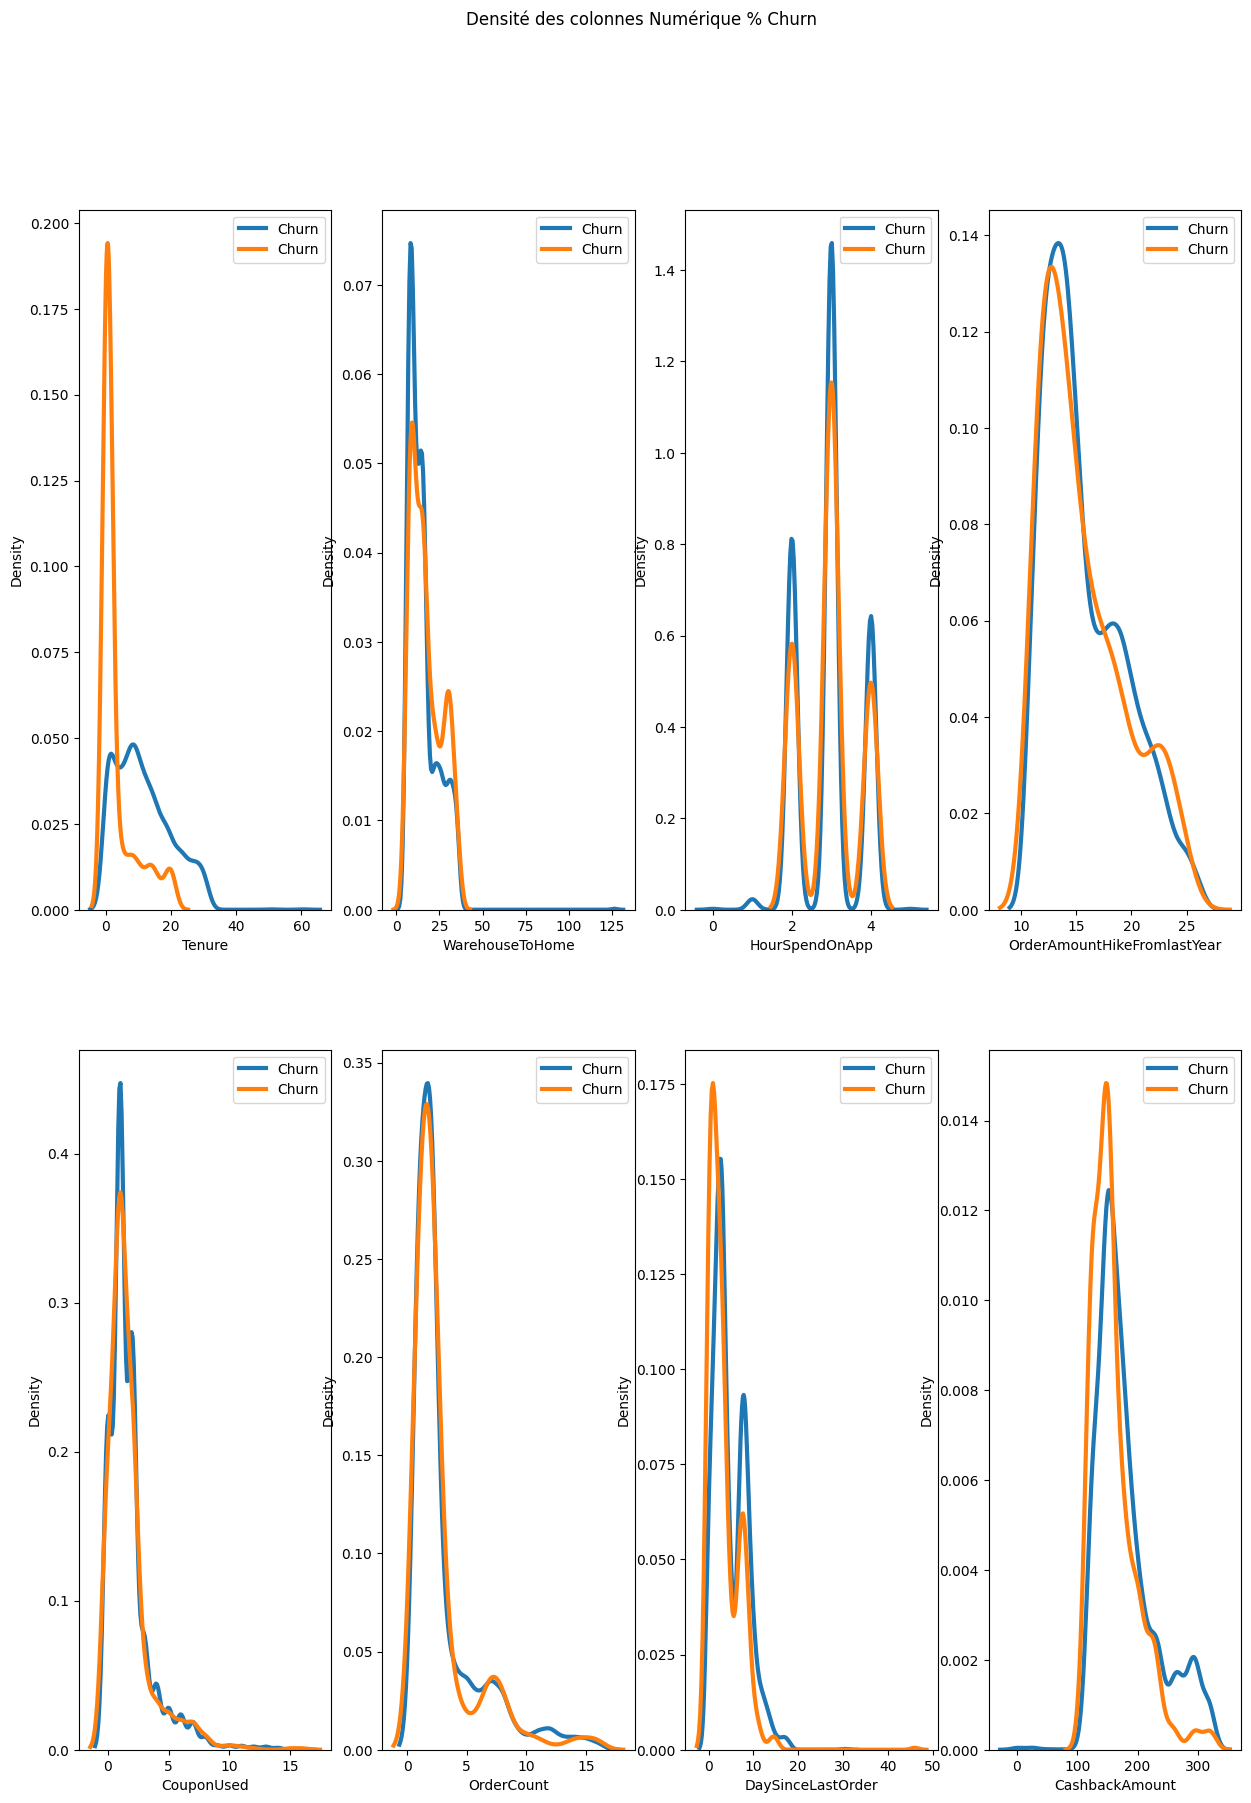

In [10]:

df_c = df[df['Churn']==0]
df_nc = df[df['Churn']==1]

fig, ax= plt.subplots(2,4 , figsize=(15,20))
fig.suptitle('Densité des colonnes Numérique % Churn')
ax = ax.flatten()

for i, c in enumerate(num_colonnes):
    sn.kdeplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    sn.kdeplot(df_nc[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    ax[i].legend(loc='upper right')

plt.show()
     

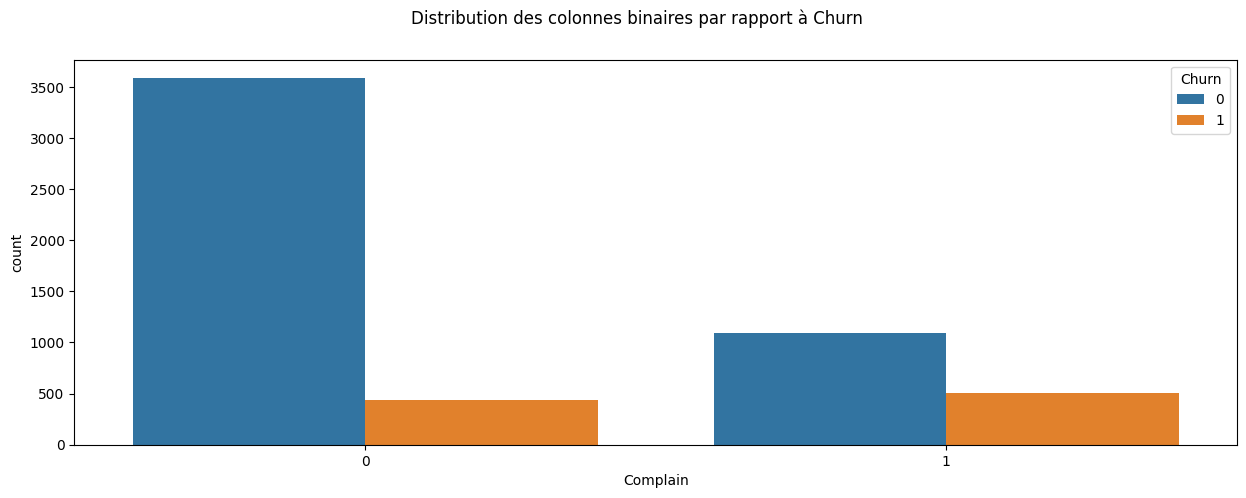

In [11]:
fig, ax = plt.subplots(1, len(colonne_cat_binaire), figsize=(15, 5))
fig.suptitle('Distribution des colonnes binaires par rapport à Churn')

for i, c in enumerate(colonne_cat_binaire):
    sn.countplot(x=c, hue='Churn', data=df, ax=ax if len(colonne_cat_binaire) == 1 else ax[i])
    ax.legend(title='Churn', loc='upper right')  # Pas besoin de [i] ici

plt.show()


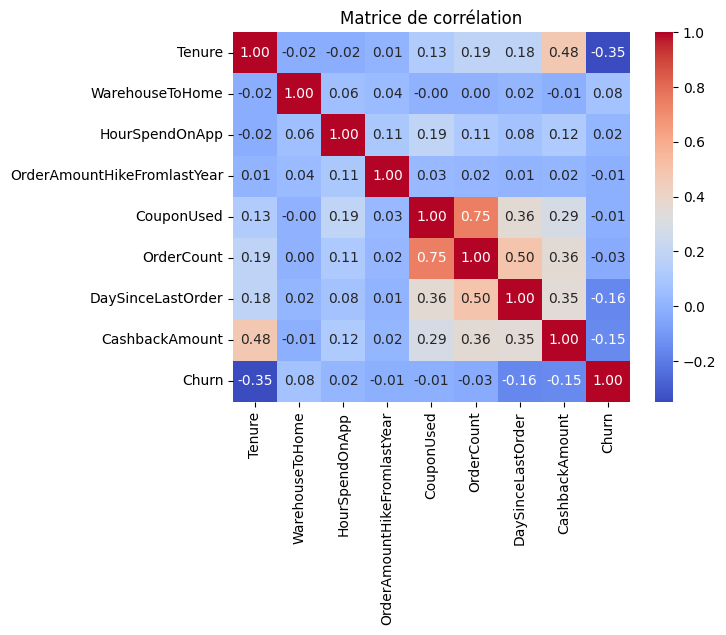

In [12]:
correlation_matrix = df_new[num_colonnes + ['Churn']].astype(float).corr()
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()


Cela signifie que les clients qui ont une durée d'abonnement plus longue, qui passent plus de commandes, qui passent plus de temps sur l'application, qui utilisent des coupons et qui ont un score de satisfaction plus élevé sont moins susceptibles de churner.

In [13]:

# Définir les colonnes numériques et catégorielles
numeric_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp']
categorical_features = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']

# Créer les transformateurs pour les valeurs manquantes et l'encodage
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Appliquer les transformations aux colonnes spécifiques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Créer le pipeline complet avec le préprocesseur et le modèle RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.2, random_state=42)

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Évaluer le modèle
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9342806394316163


Matrice de confusion:
[[924  17]
 [ 57 128]]


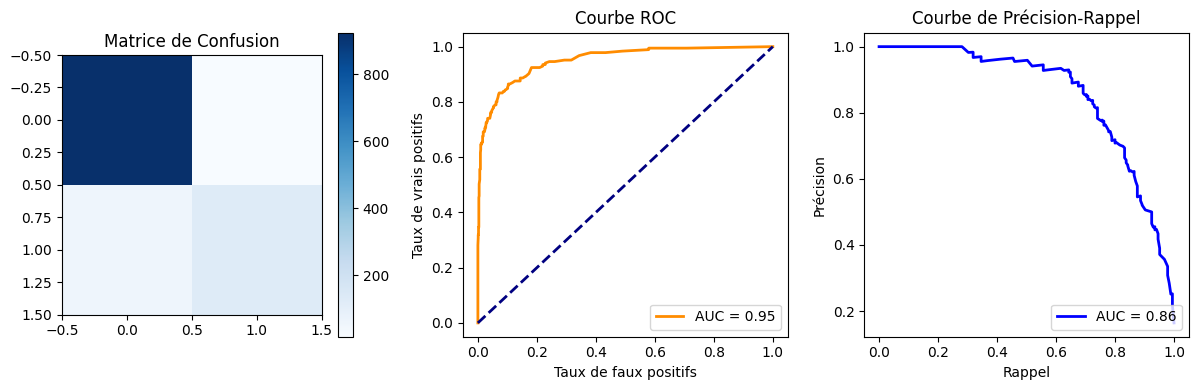

In [14]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Prédire les étiquettes sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(cm)

# Courbe ROC
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Courbe de précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Tracer les graphiques
plt.figure(figsize=(12, 4))

# Matrice de confusion
plt.subplot(1, 3, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.colorbar()

# Courbe ROC
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

# Courbe de précision-rappel
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision-Rappel')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


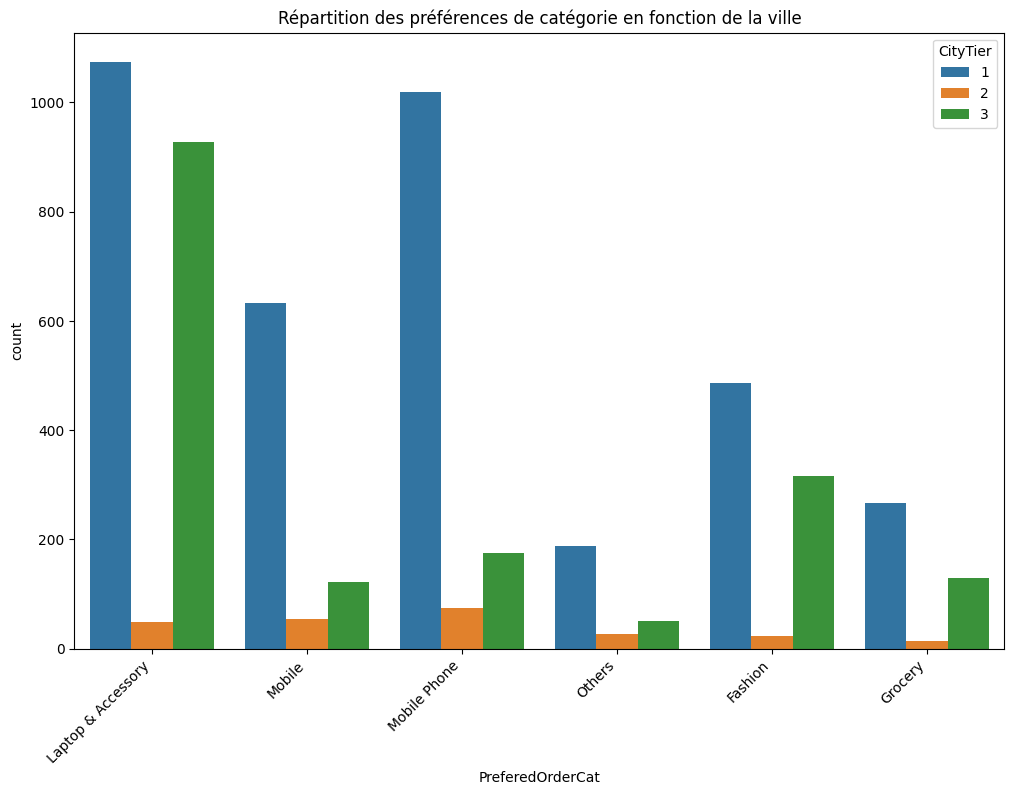

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.countplot(x='PreferedOrderCat', hue='CityTier', data=df)
plt.title('Répartition des préférences de catégorie en fonction de la ville')
plt.xticks(rotation=45, ha='right')
plt.show()

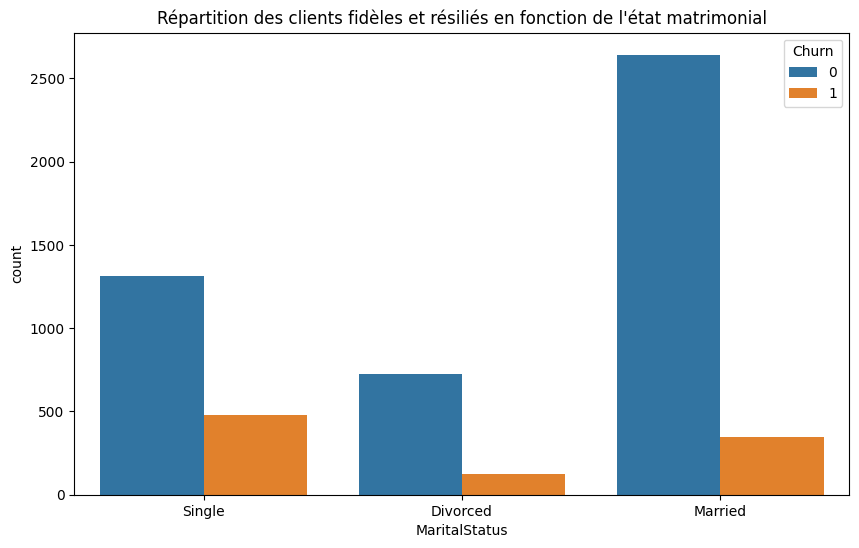

In [16]:
# Répartition des clients fidèles et résiliés en fonction de l'état matrimonial
plt.figure(figsize=(10, 6))
sns.countplot(x='MaritalStatus', hue='Churn', data=df)
plt.title('Répartition des clients fidèles et résiliés en fonction de l\'état matrimonial')
plt.show()